# Test du HSJ sur différents modèles

Import des librairies

In [1]:
import sys
import os

root_dir = os.getcwd().split("AdversarialNIDS")[0] + "AdversarialNIDS"
sys.path.append(root_dir)

import numpy as np
import torch

from CICIDS2017.dataset import CICIDS2017
from UNSWNB15.dataset import UNSWNB15

from scripts.logger import SimpleLogger

from art.attacks.evasion import HopSkipJump
from art.estimators.classification import SklearnClassifier, PyTorchClassifier

from NIDS_attacks.bounds_constrains import apply_bounds_constraints
from NIDS_attacks.integers_constrains import apply_integer_constraints

from scripts.models.decision_tree.decision_tree import train_decision_tree
from scripts.models.random_forest.random_forest import train_random_forest
from scripts.models.knn.knn import train_knn

from scripts.analysis.model_analysis import perform_model_analysis

from NIDS_attacks.hsj_attack_generalized import hsj_attack_generalized

Import du dataset

In [2]:
ds = CICIDS2017().optimize_memory().encode()
#ds = UNSWNB15().optimize_memory().encode()
ds = ds.subset(size=10000, multi_class=True)
X_train, X_test, y_train, y_test = ds.split(test_size=0.2, apply_smote=True)

[INFO] Downloading dataset: sweety18/cicids2017-full-dataset
[INFO] Loading dataset into DataFrame
[DEBUG] /home/loup/.cache/kagglehub/datasets/sweety18/cicids2017-full-dataset/versions/1/combine.csv
[INFO] Loading dataset into DataFrame
[DEBUG] /home/loup/.cache/kagglehub/datasets/sweety18/cicids2017-full-dataset/versions/1/combine.csv
[INFO] Initial dimensions: 2,214,469 rows x 79 columns = 174,943,051 cells
[DEBUG] Cleaning column names
[INFO] Initial dimensions: 2,214,469 rows x 79 columns = 174,943,051 cells
[DEBUG] Cleaning column names
[DEBUG] Removing duplicate rows
[DEBUG] Removing duplicate rows
[DEBUG] Removed 271,598 duplicate rows. Remaining: 1,942,871
[DEBUG] Removing rows with missing values (initial pass)
[DEBUG] Removed 271,598 duplicate rows. Remaining: 1,942,871
[DEBUG] Removing rows with missing values (initial pass)
[DEBUG] Removed 178 rows with missing values. Remaining: 1,942,693
[DEBUG] Checking for infinite values in numeric columns
[DEBUG] Removed 178 rows wit

Choix des contraintes

In [3]:
integer_indices = [0, 2, 5, 10, 15] # Exemple
modifiable_indices = list(range(20))

## 1.Decision Tree

In [4]:
model_dt, _ = train_decision_tree(X_train, y_train, max_depth=10)

results_dt = hsj_attack_generalized(
        model=model_dt,
        X_test=X_test,
        y_test=y_test,
        dataset="CICIDS2017",
        #dataset="UNSWNB15",
        nb_samples=20,  # Réduire pour les tests
        integer_indices=integer_indices,
        modifiable_indices=modifiable_indices,
        apply_constraints=True,
        per_sample_visualization=False  # Désactiver pour réduire le bruit
    )

[INFO] Starting Generalized HopSkipJump attack on CICIDS2017
[INFO] Using targeted class: 0
[INFO] Applying constraints with 20 modifiable features
[INFO] Integer constraints on 5 features
[INFO] Initial accuracy: 0.994
[INFO] Attacking 20 attack samples to make them appear benign...
[INFO] Target classes being attacked: [1. 2. 3.]


HopSkipJump:   0%|          | 0/20 [00:00<?, ?it/s]

[INFO] === Attack Results ===
[INFO] Original accuracy on attack samples: 1.000
[INFO] Adversarial accuracy on attack samples: 0.750
[INFO] Attack success rate (attacks -> benign): 0.250
[INFO] Average L2 perturbation: 0.434494
[INFO] Constraints applied: bounds + 5 integer features
[INFO] 
Summary: Attack succeeded 25.0% of the time


[INFO] Running analysis for scikit-learn model: Decision Tree - Dataset Original
[DEBUG] 
Classification Report for Decision Tree - Dataset Original
              precision    recall  f1-score   support

         0.0     0.9905    0.9867    0.9886       528
         1.0     1.0000    0.9980    0.9990       492
         2.0     0.9873    0.9894    0.9883       471
         3.0     0.9961    1.0000    0.9980       509

    accuracy                         0.9935      2000
   macro avg     0.9935    0.9935    0.9935      2000
weighted avg     0.9935    0.9935    0.9935      2000




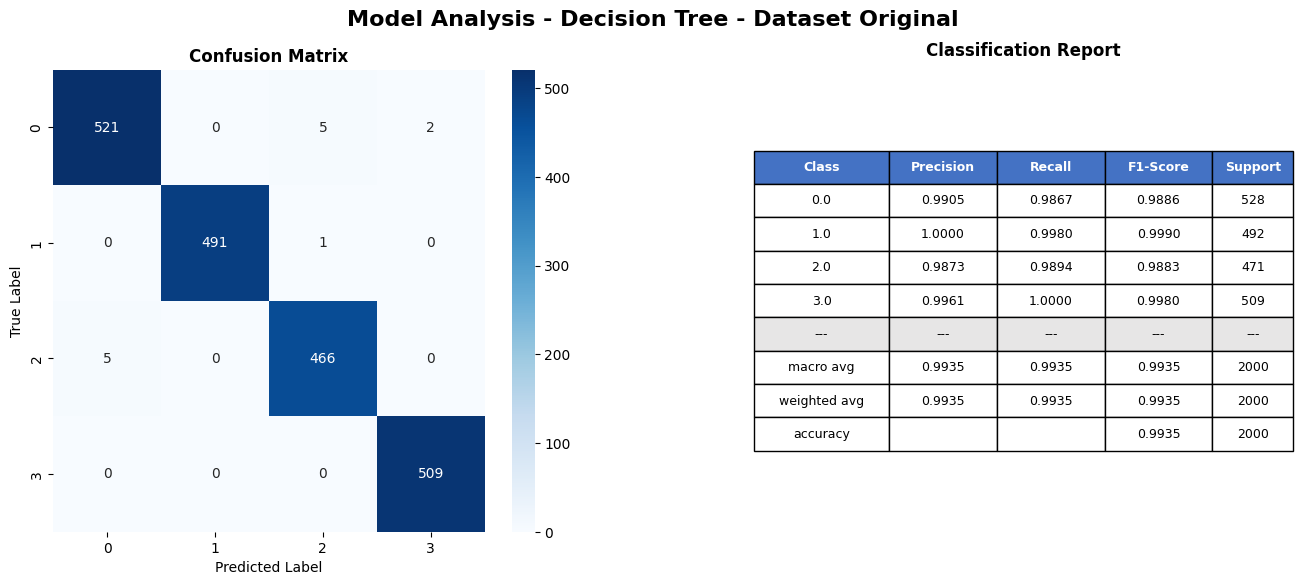

[INFO] Running analysis for scikit-learn model: Decision Tree - Dataset Adverserial
[DEBUG] 
Classification Report for Decision Tree - Dataset Adverserial
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000         0
         1.0     1.0000    0.1667    0.2857         6
         2.0     1.0000    1.0000    1.0000         6
         3.0     1.0000    1.0000    1.0000         8

    accuracy                         0.7500        20
   macro avg     0.7500    0.5417    0.5714        20
weighted avg     1.0000    0.7500    0.7857        20




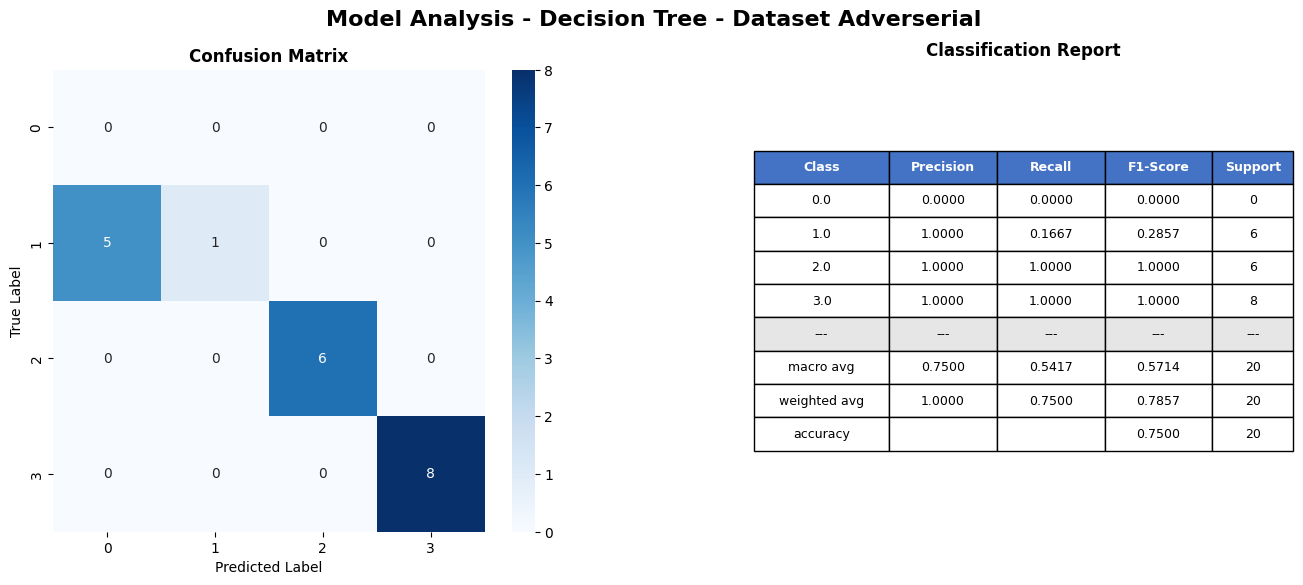

In [5]:
logger = SimpleLogger()
cm_orig, report_orig = perform_model_analysis(
    model=model_dt,
    X_test=X_test,
    y_test=y_test,
    logger=logger,
    title="Decision Tree - Dataset Original",
    plot=True,
    save_fig=False
)

cm_adv, report_adv = perform_model_analysis(
    model=model_dt,
    X_test=results_dt['X_adv'],
    y_test=results_dt['y_attacks'],
    logger=logger,
    title="Decision Tree - Dataset Adverserial",
    plot=True,
    save_fig=False
)

## 2.Random Forest

In [ ]:
model_rf, _ = train_random_forest(X_train, y_train, n_estimators=5, max_depth=7)

results_rf = hsj_attack_generalized(
        model=model_rf,
        X_test=X_test,
        y_test=y_test,
        dataset="CICIDS2017",
        #dataset="UNSWNB15",
        nb_samples=10,
        integer_indices=integer_indices,
        modifiable_indices=modifiable_indices,
        apply_constraints=True,
        per_sample_visualization=True
    )

[INFO] Starting Generalized HopSkipJump attack on CICIDS2017
[INFO] Using targeted class: 0
[INFO] Applying constraints with 20 modifiable features
[INFO] Integer constraints on 5 features
[INFO] Initial accuracy: 0.996
[INFO] Attacking 10 attack samples to make them appear benign...
[INFO] Target classes being attacked: [1. 2. 3.]


HopSkipJump:   0%|          | 0/10 [00:00<?, ?it/s]

[INFO] === Attack Results ===
[INFO] Original accuracy on attack samples: 1.000
[INFO] Adversarial accuracy on attack samples: 1.000
[INFO] Attack success rate (attacks -> benign): 0.000
[INFO] Average L2 perturbation: 85.208927
[INFO] Constraints applied: bounds + 5 integer features
[INFO] === Per-Sample Analysis ===
[INFO] Sample 1: Class 2.0 -> Original pred: 2.0 -> Adversarial pred: 2.0
[INFO] Sample 2: Class 3.0 -> Original pred: 3.0 -> Adversarial pred: 3.0
[INFO] Sample 3: Class 3.0 -> Original pred: 3.0 -> Adversarial pred: 3.0
[INFO] Sample 4: Class 3.0 -> Original pred: 3.0 -> Adversarial pred: 3.0
[INFO] Sample 5: Class 2.0 -> Original pred: 2.0 -> Adversarial pred: 2.0
[INFO] Sample 6: Class 3.0 -> Original pred: 3.0 -> Adversarial pred: 3.0
[INFO] Sample 7: Class 2.0 -> Original pred: 2.0 -> Adversarial pred: 2.0
[INFO] Sample 8: Class 3.0 -> Original pred: 3.0 -> Adversarial pred: 3.0
[INFO] Sample 9: Class 1.0 -> Original pred: 1.0 -> Adversarial pred: 1.0
[INFO] Sample 

[INFO] Running analysis for scikit-learn model: Random Forest - Dataset Original
[DEBUG] 
Classification Report for Random Forest - Dataset Original
              precision    recall  f1-score   support

         0.0     0.9924    0.9905    0.9915       528
         1.0     1.0000    1.0000    1.0000       492
         2.0     0.9936    0.9915    0.9926       471
         3.0     0.9961    1.0000    0.9980       509

    accuracy                         0.9955      2000
   macro avg     0.9955    0.9955    0.9955      2000
weighted avg     0.9955    0.9955    0.9955      2000




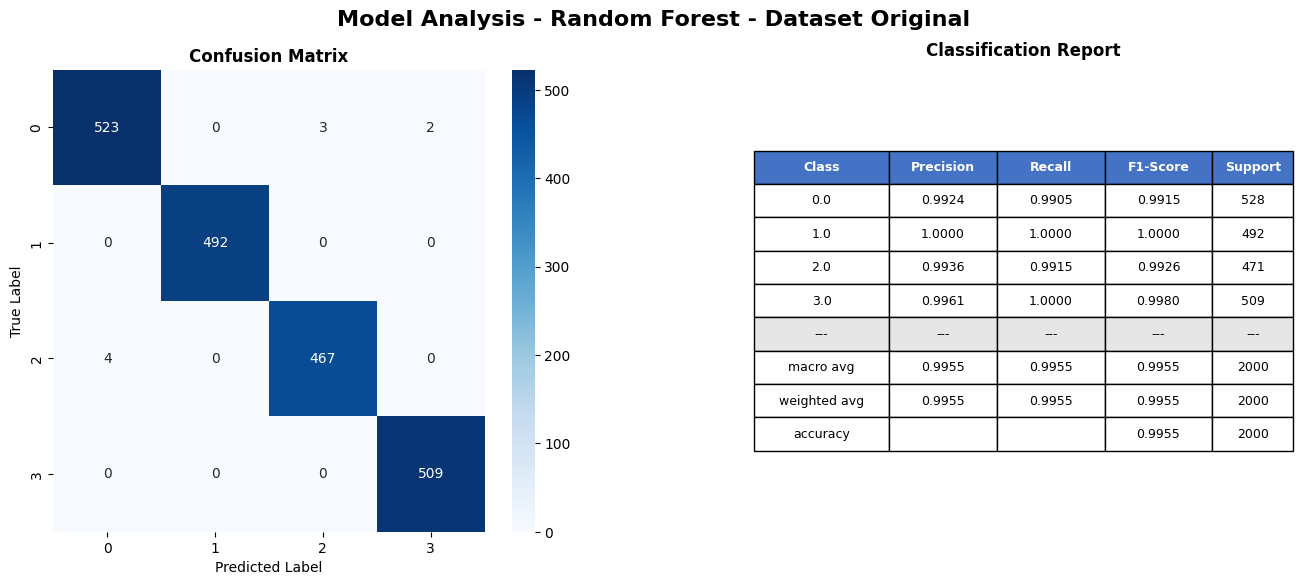

[INFO] Running analysis for scikit-learn model: Random Forest - Dataset Adverserial
[DEBUG] 
Classification Report for Random Forest - Dataset Adverserial
              precision    recall  f1-score   support

         1.0     1.0000    1.0000    1.0000         1
         2.0     1.0000    1.0000    1.0000         4
         3.0     1.0000    1.0000    1.0000         5

    accuracy                         1.0000        10
   macro avg     1.0000    1.0000    1.0000        10
weighted avg     1.0000    1.0000    1.0000        10




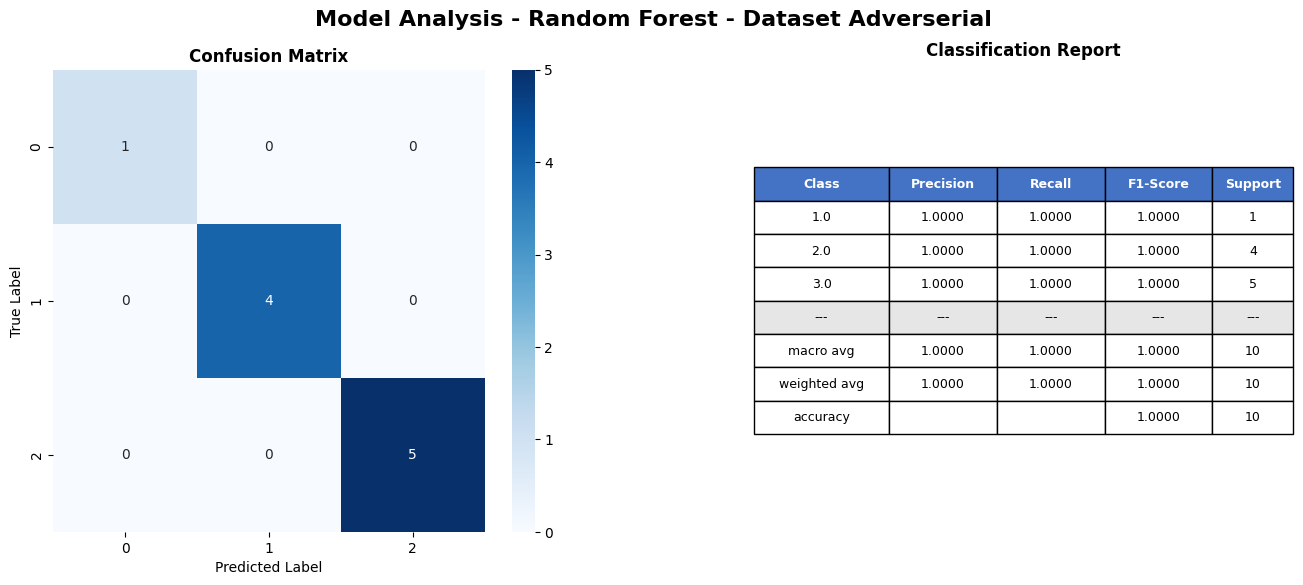

In [7]:
logger = SimpleLogger()
cm_orig, report_orig = perform_model_analysis(
    model=model_rf,
    X_test=X_test,
    y_test=y_test,
    logger=logger,
    title="Random Forest - Dataset Original",
    plot=True,
    save_fig=False
) # Does not work

cm_adv, report_adv = perform_model_analysis(
    model=model_rf,
    X_test=results_rf['X_adv'],
    y_test=results_rf['y_attacks'],
    logger=logger,
    title="Random Forest - Dataset Adverserial",
    plot=True,
    save_fig=False
)

## 3.KNN

In [8]:
model_knn, _ = train_knn(X_train, y_train, n_neighbors=5)

results_knn = hsj_attack_generalized(
        model=model_knn,
        X_test=X_test,
        y_test=y_test,
        dataset="CICIDS2017",
        #dataset="UNSWNB15",
        nb_samples=10,
        integer_indices=integer_indices,
        modifiable_indices=modifiable_indices,
        apply_constraints=True,
        per_sample_visualization=True
    )

[INFO] Starting Generalized HopSkipJump attack on CICIDS2017
[INFO] Using targeted class: 0
[INFO] Applying constraints with 20 modifiable features
[INFO] Integer constraints on 5 features
[INFO] Initial accuracy: 0.962
[INFO] Attacking 10 attack samples to make them appear benign...
[INFO] Target classes being attacked: [1. 2. 3.]


HopSkipJump:   0%|          | 0/10 [00:00<?, ?it/s]

[INFO] === Attack Results ===
[INFO] Original accuracy on attack samples: 1.000
[INFO] Adversarial accuracy on attack samples: 1.000
[INFO] Attack success rate (attacks -> benign): 0.000
[INFO] Average L2 perturbation: 7570020.360846
[INFO] Constraints applied: bounds + 5 integer features
[INFO] === Per-Sample Analysis ===
[INFO] Sample 1: Class 2.0 -> Original pred: 2.0 -> Adversarial pred: 2.0
[INFO] Sample 2: Class 3.0 -> Original pred: 3.0 -> Adversarial pred: 3.0
[INFO] Sample 3: Class 3.0 -> Original pred: 3.0 -> Adversarial pred: 3.0
[INFO] Sample 4: Class 3.0 -> Original pred: 3.0 -> Adversarial pred: 3.0
[INFO] Sample 5: Class 2.0 -> Original pred: 2.0 -> Adversarial pred: 2.0
[INFO] Sample 6: Class 3.0 -> Original pred: 3.0 -> Adversarial pred: 3.0
[INFO] Sample 7: Class 2.0 -> Original pred: 2.0 -> Adversarial pred: 2.0
[INFO] Sample 8: Class 3.0 -> Original pred: 3.0 -> Adversarial pred: 3.0
[INFO] Sample 9: Class 1.0 -> Original pred: 1.0 -> Adversarial pred: 1.0
[INFO] Sa

[INFO] Running analysis for scikit-learn model: K-Nearest Neighbors - Dataset Original
[DEBUG] 
Classification Report for K-Nearest Neighbors - Dataset Original
              precision    recall  f1-score   support

         0.0     0.9736    0.9072    0.9392       528
         1.0     0.9698    0.9797    0.9747       492
         2.0     0.9381    0.9660    0.9519       471
         3.0     0.9658    0.9980    0.9816       509

    accuracy                         0.9620      2000
   macro avg     0.9618    0.9627    0.9619      2000
weighted avg     0.9623    0.9620    0.9617      2000




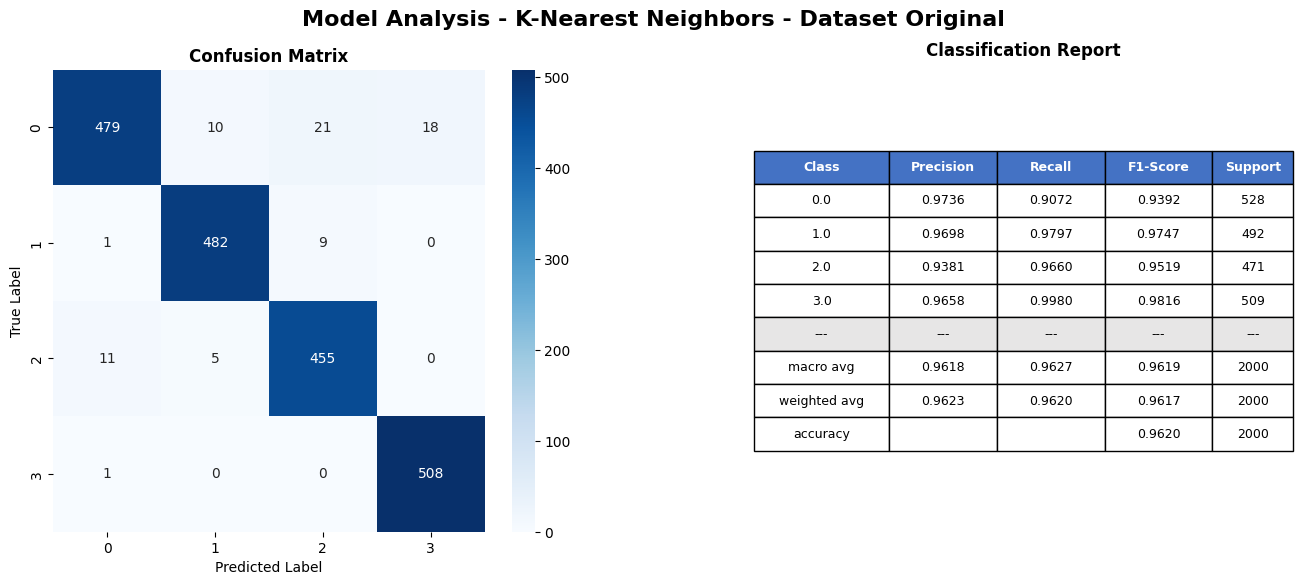

[INFO] Running analysis for scikit-learn model: K-Nearest Neighbors - Dataset Adverserial
[DEBUG] 
Classification Report for K-Nearest Neighbors - Dataset Adverserial
              precision    recall  f1-score   support

         1.0     1.0000    1.0000    1.0000         1
         2.0     1.0000    1.0000    1.0000         4
         3.0     1.0000    1.0000    1.0000         5

    accuracy                         1.0000        10
   macro avg     1.0000    1.0000    1.0000        10
weighted avg     1.0000    1.0000    1.0000        10




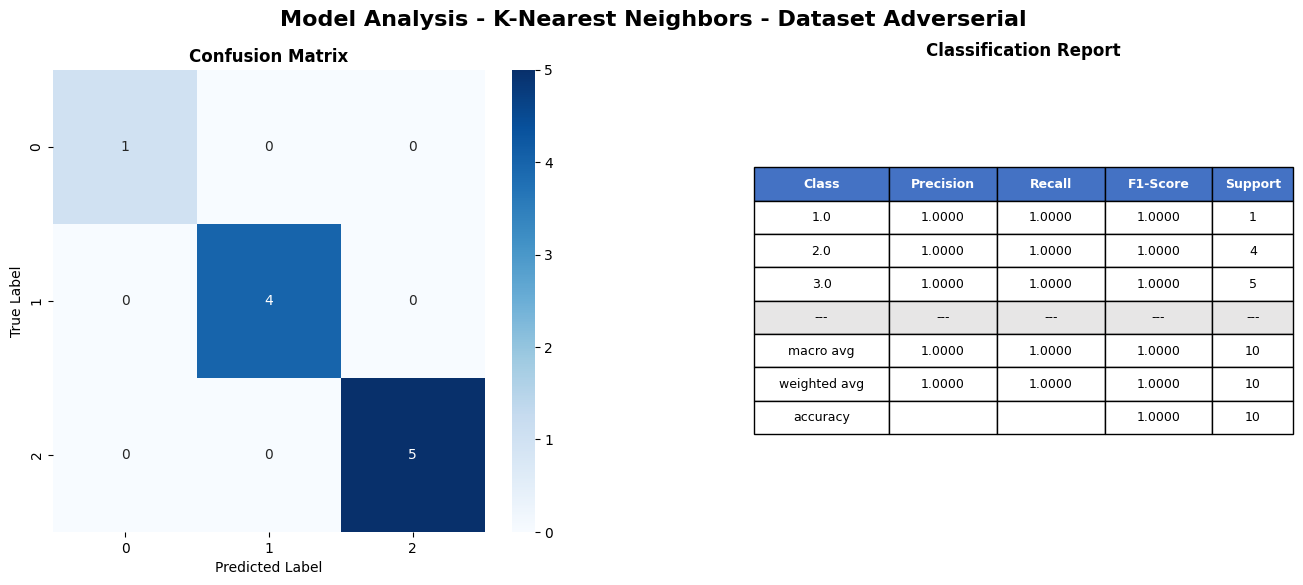

In [9]:
logger = SimpleLogger()
cm_orig, report_orig = perform_model_analysis(
    model=model_knn,
    X_test=X_test,
    y_test=y_test,
    logger=logger,
    title="K-Nearest Neighbors - Dataset Original",
    plot=True,
    save_fig=False
)

cm_adv, report_adv = perform_model_analysis(
    model=model_knn,
    X_test=results_knn['X_adv'],
    y_test=results_knn['y_attacks'],
    logger=logger,
    title="K-Nearest Neighbors - Dataset Adverserial",
    plot=True,
    save_fig=False
)